# Config and Setup

## Imports

In [1]:
# utils
from google.colab import drive
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import pdb
import numpy as np
import pandas as pd

# torch
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image

# sklearn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

ModuleNotFoundError: No module named 'google.colab'

## Config

In [ ]:
# pytorch gpu config
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.cuda.manual_seed_all(seed)
else:
  device = torch.device("cpu")
print(device)

cuda


## Downloading and Extracting Data
The creation of these datasets is described in the following notebooks:
*   [DiffusionDB Data](https://github.com/JensenZhaoUT/MIE1517_Project/blob/main/EDA%20-%20Generated.ipynb)
*   [WikiArt Data](https://github.com/JensenZhaoUT/MIE1517_Project/blob/main/WikiArt%20EDA.ipynb)



In [ ]:
# download the datasets to working directory
!gdown 1M-RNViW7mhnedbFxwdrOIW5Y46Eri8sY # diffusiondb_256
!gdown 1VVySTFhHVLipFTZoHKv3J9jokjMxXvBa # paintings_256

# create directories for data and unzip archives
!mkdir -p /content/diffusiondb
!mkdir -p /content/wikiart
!unzip -u /content/cropped_diffusiondb_256.zip -d /content/diffusiondb
!unzip -u /content/cropped_paintings_256.zip -d /content/wikiart

## Creating Custom Dataset

In [ ]:
from PIL import Image
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset

class CustomImageDataset(Dataset):
    def __init__(self, directory, label, max_images=None):
        self.directory = directory
        self.label = label
        all_images = [file for file in os.listdir(directory) if file.endswith('.jpg')]

        # Filter images with resolution between 400 and 600
        self.images = []
        for img_file in all_images:
            img_path = os.path.join(self.directory, img_file)
            with Image.open(img_path) as img:
                if 400 <= max(img.size) <= 600:
                    self.images.append(img_file)

        self.transform = transforms.ToTensor()  # Define the transform here

        # If max_images is set, randomly select a subset of images
        if max_images is not None and max_images <= len(self.images):
            self.images = random.sample(self.images, max_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path)
        image = self.transform(image)  # Transform the image to a tensor
        # load image with gpu if available
        if torch.cuda.is_available():
            image = image.to(torch.device('cuda:0'))
        return image, self.label
    

# Determine the number of images in the smaller dataset
num_images_in_smaller_dataset = len([file for file in os.listdir('/content/diffusiondb') if file.endswith('.jpg')])

# for demonstration purposes, define smaller dataset size
data_size = 800


# Create dataset with true and false labels
dataset_false = CustomImageDataset('/content/diffusiondb', 0, max_images=data_size)
dataset_true = CustomImageDataset('/content/wikiart', 1, max_images=data_size) 

# Concat datasets into one
combined_dataset = ConcatDataset([dataset_false, dataset_true])

In [ ]:
# class CustomImageDataset(Dataset):
#     def __init__(self, directory, label, max_images=None):
#         self.directory = directory
#         self.label = label
#         self.images = [file for file in os.listdir(directory) if file.endswith('.jpg')]
#         self.transform = transforms.ToTensor()  # Define the transform here

#         # If max_images is set, randomly select a subset of images
#         if max_images is not None and max_images <= len(self.images):
#             self.images = random.sample(self.images, max_images)

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.directory, self.images[idx])
#         image = Image.open(img_path)
#         image = self.transform(image)  # Transform the image to a tensor
#         # load image with gpu if available
#         if torch.cuda.is_available():
#             image = image.to(torch.device('cuda:0'))
#         return image, self.label


# # Determine the number of images in the smaller dataset
# num_images_in_smaller_dataset = len([file for file in os.listdir('/content/diffusiondb') if file.endswith('.jpg')])

# # for demonstration purposes, define smaller dataset size
# data_size = 800


# # Create dataset with true and false labels
# dataset_false = CustomImageDataset('/content/diffusiondb', 0, max_images=data_size)
# dataset_true = CustomImageDataset('/content/wikiart', 1, max_images=data_size) 

# # Concat datasets into one
# combined_dataset = ConcatDataset([dataset_false, dataset_true])

In [ ]:
# Train-Validation-Test Split
length_of_combined_dataset = len(combined_dataset)
print(f'Length of dataset: {length_of_combined_dataset}')

# define split size
train_size = int(0.7 * length_of_combined_dataset)  # 70% for training
val_size = int(0.1 * length_of_combined_dataset)   # 10% for validation
test_size = length_of_combined_dataset - train_size - val_size  # Remaining 20% for testing

# perform the split
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

Length of dataset: 1600


# Model

## Model Definition

In [ ]:
class MyConvNet(nn.Module):
  def __init__(self, lr=0.01, criterion=nn.BCELoss):
    super(MyConvNet, self).__init__()

    # define params
    self.lr = lr
    self.criterion = criterion()


    # build the encoder and classifier
    self.encoder = self.build_encoder()
    self.classifier = self.build_classifier()


  def build_encoder(self):
    encoder = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, stride = 2, padding = 0), # (8,254,254) / (8,126,126)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 4, stride = 1, padding = 0), # (8, 251, 251) / (8,123,123)
      nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 9, stride = 2, padding = 0), # (10,122,122) / (10,58,58)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 4, stride = 1 , padding = 0), # (10, 119, 119) / (10,55,55)
      )
    return encoder

  def build_classifier(self):
    classifier = nn.Sequential(
      nn.Flatten(start_dim=1),
      nn.Linear(10*55**2, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
    )
    return classifier


  def forward(self, img):
    return self.classifier(self.encoder(img.to(torch.float)))

  def train(self, data, val_data, n_epochs=20, batch_size=15, optimizer=torch.optim.Adam):
    # read params and assign
    self.batch_size = batch_size
    train_loader = DataLoader(dataset=data, shuffle=True, batch_size=self.batch_size)
    val_loader = DataLoader(dataset=val_data, shuffle=True, batch_size=self.batch_size)

    # define optimizer
    self.optimizer = optimizer(self.parameters(), lr = self.lr)
    n_training_steps = len(train_loader)
    n_val_steps = len(val_loader)


    train_losses_epochs = []
    val_losses_epochs = []

    for epoch in range(n_epochs):
      output = []
      batch_accuracies = []
      train_losses = []
      # training loop
      for i, (x_train, y_train) in enumerate(train_loader):
        # fix typing of labels
        y_train = y_train.type(torch.FloatTensor).unsqueeze(1)
        # make sure we are using cuda
        if torch.cuda.is_available():
          x_train = x_train.to(torch.device('cuda:0'))
          y_train = y_train.to(torch.device('cuda:0'))
        # forward step
        y_pred = self.forward(x_train)
        # get loss
        loss = self.criterion(y_pred, y_train)

        # backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # add outputs to list
        output.append(y_pred)
        # add loss to list
        train_losses.append(loss.item())

        # get accuracy
        correct = (y_pred.round() == y_train).type(torch.float).sum().item()
        accuracy_batch = 100*correct/len(x_train)
        batch_accuracies.append(accuracy_batch)

        # print batch info
        if (i+1 == n_training_steps):
          avg_loss = sum(train_losses)/len(train_losses)
          # add average loss to training losses
          train_losses_epochs.append(avg_loss)
          # get accuracy of epoch
          accuracy = sum(batch_accuracies)/len(batch_accuracies)
          # print current epoch info
          print(f'Epoch {epoch+1}/{n_epochs} : Train Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}')


      # validation loop
      batch_accuracies = []
      val_losses = []
      for i, (x_val, y_val) in enumerate(val_loader):
        # fix typing of labels
        y_val = y_val.type(torch.FloatTensor).unsqueeze(1)
        if torch.cuda.is_available():
          x_val = x_val.to(torch.device('cuda:0'))
          y_val = y_val.to(torch.device('cuda:0'))
        # forward step
        y_val_pred = self.forward(x_val)
        # get loss
        loss = self.criterion(y_val_pred, y_val)
        # get accuracy
        correct = (y_val_pred.round() == y_val).type(torch.float).sum().item()
        accuracy_batch = 100*correct/len(x_val)
        batch_accuracies.append(accuracy_batch)
        val_losses.append(loss.item())

        if (i+1 == n_val_steps):
          # get loss and accuracy
          avg_loss = sum(val_losses)/len(val_losses)
          accuracy = sum(batch_accuracies)/len(batch_accuracies)
          # add average loss to validation losses
          val_losses_epochs.append(avg_loss)
          print(f'Epoch {epoch+1}/{n_epochs} : Validation Accuracy: {accuracy:.2f}%, Validation Loss: {avg_loss:.4f}')



    return train_losses_epochs, val_losses_epochs, output

## Model Training

In [ ]:
# init net
net = MyConvNet(lr=0.0005)
# use gpu if available
if torch.cuda.is_available():
  net = net.to(torch.device('cuda:0'))
# training loop
train_losses, val_losses, output = net.train(train_dataset, val_dataset, batch_size=3, n_epochs=8)
print('Finished Training')

Epoch 1/8 : Train Accuracy: 63.55%, Avg Loss: 0.6523
Epoch 1/8 : Validation Accuracy: 72.84%, Validation Loss: 0.6135
Epoch 2/8 : Train Accuracy: 68.98%, Avg Loss: 0.6032
Epoch 2/8 : Validation Accuracy: 70.99%, Validation Loss: 0.5801
Epoch 3/8 : Train Accuracy: 69.79%, Avg Loss: 0.5729
Epoch 3/8 : Validation Accuracy: 72.84%, Validation Loss: 0.5745
Epoch 4/8 : Train Accuracy: 71.75%, Avg Loss: 0.5486
Epoch 4/8 : Validation Accuracy: 69.14%, Validation Loss: 0.6055
Epoch 5/8 : Train Accuracy: 73.62%, Avg Loss: 0.5262
Epoch 5/8 : Validation Accuracy: 72.22%, Validation Loss: 0.5763
Epoch 6/8 : Train Accuracy: 73.89%, Avg Loss: 0.5105
Epoch 6/8 : Validation Accuracy: 74.07%, Validation Loss: 0.5310
Epoch 7/8 : Train Accuracy: 77.45%, Avg Loss: 0.4878
Epoch 7/8 : Validation Accuracy: 70.99%, Validation Loss: 0.5841
Epoch 8/8 : Train Accuracy: 77.27%, Avg Loss: 0.4785
Epoch 8/8 : Validation Accuracy: 73.46%, Validation Loss: 0.5489
Finished Training


### Training Visualization

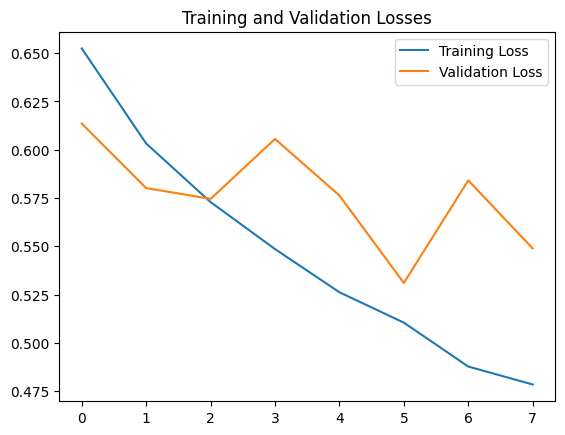

In [ ]:
# plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# add title and legend
plt.legend()
plt.title('Training and Validation Losses')

# display plot
plt.show()

## Model Evaluation

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

batch_accuracies = []
# test loop
for x_test, y_test in test_loader:
  # fix typing of labels
  y_test = y_test.type(torch.FloatTensor).unsqueeze(1)
  if torch.cuda.is_available():
    x_test = x_test.to(torch.device('cuda:0'))
    y_test = y_test.to(torch.device('cuda:0'))
  y_pred = net.forward(x_test)
  correct = (y_pred.round() == y_test).type(torch.float).sum().item()
  accuracy_batch = 100*correct/len(x_test)
  batch_accuracies.append(accuracy_batch)

print(f'Test Accuracy: {sum(batch_accuracies)/len(batch_accuracies):.2f}%')

Test Accuracy: 73.12%


In [ ]:
# get test predictions and labels
test_preds = np.round(y_pred.cpu().detach().numpy())
test_labels = y_test.cpu().detach().numpy()

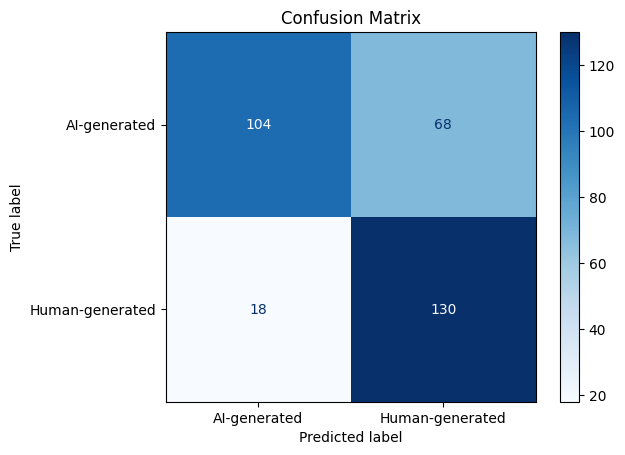

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.60      0.71       172
         1.0       0.66      0.88      0.75       148

    accuracy                           0.73       320
   macro avg       0.75      0.74      0.73       320
weighted avg       0.76      0.73      0.73       320



In [ ]:
# create confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-generated", "Human-generated"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# display classification report
report = classification_report(test_labels, test_preds)
print("Classification Report:\n", report)